In [622]:
import pandas as pd
import numpy as np
import os,fnmatch
import xarray as xr
import katdal
import matplotlib.pylab as plt
from matplotlib import rcParams
from functools import reduce
import pandas.core.nanops as nanops
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
rcParams['figure.figsize'] = (11.7,8.27)
rcParams['font.size']=13

In [2]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [381]:
data1 = np.load('/data/isaac/DR1/DR1_O_Data_FT.npy')
data0 = np.load('/data/isaac/DR0/DR0_O_Data_FT.npy')

In [382]:
Data = []
mon =[]
for i in range(len(data1)):
    if data1[i][1][5:][0] == '0':
        Data.append([data1[0][0],int(data1[i][1][5:][1])])
        mon.append(int(data1[i][1][5:][1]))
    else:
        Data.append([data1[0][0],int(data1[i][1][5:])])
        mon.append(int(data1[i][1][5:]))

In [383]:
for j in range(len(data0)):
    if str(data0[j][2])[4:][0] == '0':
        Data.append([data0[j][0],int(str(data0[j][2])[4:][1])])
        mon.append(int(str(data0[j][2])[4:][1]))
    else:
        Data.append([data0[j][0],int(str(data0[j][2])[4:6])])
        mon.append(int(str(data0[j][2])[4:6]))

In [384]:
Data = np.array(Data)

In [544]:
df1 = pd.DataFrame(Data,columns=['probability','Month'])

In [386]:
df.head()

,probability,Month
0,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",9
1,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",10
2,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",10
3,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",6
4,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",10


In [387]:
#np.where(df['Month'].values==3)

In [388]:
new_df = df.sort_values(by=['Month']).drop(df.index[76])

In [615]:
data1 = xr.open_zarr('/data/isaac/DR1/june.zarr/')
data2 = xr.open_zarr('/data/isaac/DR0June.zarr/')

In [616]:
data = data1+data2

In [617]:
m = data.master.astype(float)
c = data.counter.astype(float)

In [618]:
mm = m.sum(dim=['baseline','elevation','azimuth'])
cc = c.sum(dim=['baseline','elevation','azimuth'])

In [619]:
p = mm/cc

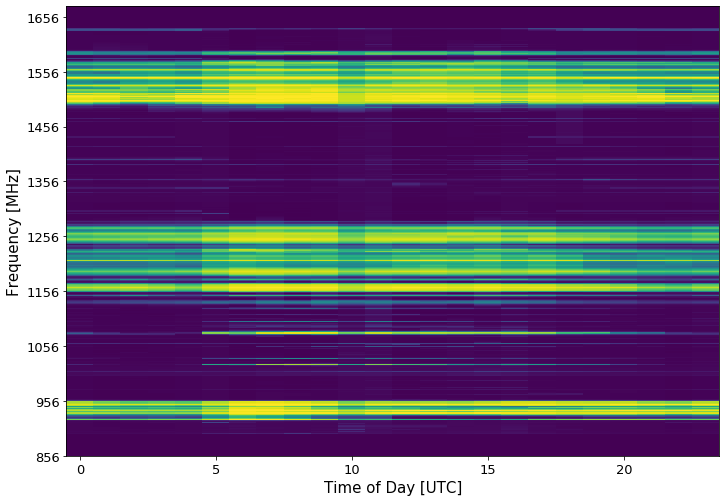

In [623]:
plt.imshow(p.T,aspect='auto')
#plt.title('June')
plt.xlabel('Time of Day [UTC]', fontsize=15)
plt.ylabel('Frequency [MHz]', fontsize=15)
plt.ylim(0,4096)
plt.yticks(np.arange(0,4096,500),np.arange(856,1712,100))
#plt.colorbar()
plt.show()

In [510]:
df = pd.read_csv('/data/isaac/DR1/resultsdr1/All_2018_imaging_observations.csv')


def Get_zarr(path2zarr):
    fls = os.listdir(path2zarr)
    zarr = []
    for f in fls:
        if 'DR1.zarr' in f:
            zarr.append(path2zarr+f)
    return zarr
            
path2zarr= '/data/isaac/DR1/resultsdr1/'
fname = Get_zarr(path2zarr)

fn = []
for i in range(len(fname)):
    fn.append('http://archive-gw-1.kat.ac.za:7480/'+fname[i][35:45]+'/'+str(fname[i][35:]))

df_new = df[df.FullLink.isin(fn)]

In [517]:
df_new['UTC_End']

1      2018-07-30 01:40:14.559000
3      2018-09-16 21:04:22.404000
4      2018-07-08 21:59:23.673000
5      2018-09-02 04:26:29.275000
8      2018-10-27 23:01:08.302000
                  ...            
327    2018-06-28 21:20:51.617000
329    2018-10-22 15:30:21.620000
338    2018-06-21 16:38:58.191000
350    2018-05-29 08:02:03.024000
355    2018-07-11 10:32:37.103000
Name: UTC_End, Length: 131, dtype: object

In [518]:
month = []
for i in range(len(df_new['UTC_End'])):
    month.append(int(df_new['UTC_End'].iloc[i][5:7]))

df_new['Month'] = month

In [552]:
mon = ['May','June','July','August','September','October','November','December']

In [553]:
FilesList = []
mon_dataset = df_new[df_new['Month']==5]['FullLink']
for j in range(len(mon_dataset)):
        FilesList.append('/data/isaac/DR1/resultsdr1/DR1.zarr'+mon_dataset.iloc[j][35:45]+'_sdp_l0.full.rdb')
        

In [554]:
Chunk0 = xr.open_zarr(FilesList[0])

MyDATA = Chunk0
for Myfiles in FilesList[1:10]:
    print(Myfiles)
    ChunkToAdd = xr.open_zarr(Myfiles)
    MyDATA = MyDATA+ChunkToAdd

/data/isaac/DR1/resultsdr1/DR1.zarr1527564238_sdp_l0.full.rdb
/data/isaac/DR1/resultsdr1/DR1.zarr1527542514_sdp_l0.full.rdb
/data/isaac/DR1/resultsdr1/DR1.zarr1527520524_sdp_l0.full.rdb
/data/isaac/DR1/resultsdr1/DR1.zarr1527587543_sdp_l0.full.rdb
/data/isaac/DR1/resultsdr1/DR1.zarr1527577770_sdp_l0.full.rdb


In [525]:
m = MyDATA.master.sum(dim=['baseline','elevation','azimuth'])
c = MyDATA.counter.sum(dim=['baseline','elevation','azimuth'])

p = m.astype(float)/c.astype(float)

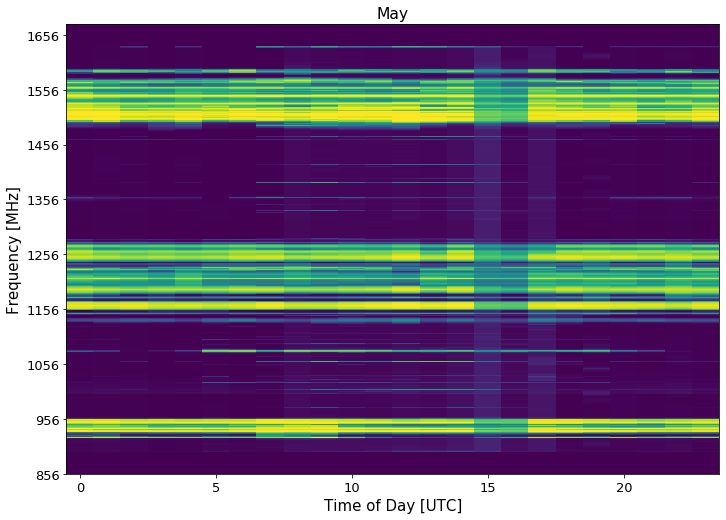

In [614]:
plt.imshow(p.T,aspect='auto')
plt.title(mon[0])
plt.xlabel('Time of Day [UTC]', fontsize=15)
plt.ylabel('Frequency [MHz]', fontsize=15)
plt.ylim(0,4096)
plt.yticks(np.arange(0,4096,500),np.arange(856,1712,100))
plt.savefig(mon[0]+'png')

In [540]:
np.arange(856,1712,100)

array([ 856,  956, 1056, 1156, 1256, 1356, 1456, 1556, 1656])

In [543]:
np.arange(0,4096,500)

array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])

In [578]:
df0 = pd.read_csv('/data/isaac/DR0/infoDR0.csv')

def Get_zarr0(path2zarr0):
    fls = os.listdir(path2zarr0)
    zarr = []
    for f in fls:
        if 'DR0.zarr1' in f:
            zarr.append(path2zarr0+f)
    return zarr
            
path2zarr0= '/data/isaac/DR0/results/'
fname0 = Get_zarr0(path2zarr0)


fn0 = []
for i in range(len(fname0)):
    fn0.append(fname0[i][32:42]+'_sdp_l0')

df_new0 = df0[df0.Filename.isin(fn0)]


month0 = []
for i in range(len(df_new0['date'])):
    month0.append(int(str(df_new0['date'].iloc[i])[4:6]))

df_new0['Month'] = month0

In [590]:
df_new0

,Unnamed: 0,Filename,obs_len,date,Month
0,0,1530510128_sdp_l0,1079.543291,20180702,7
2,2,1529209968_sdp_l0,30683.019322,20180615,6
3,3,1538843813_sdp_l0,10563.531020,20181006,10
5,5,1537201908_sdp_l0,34217.524023,20180917,9
7,7,1536252666_sdp_l0,35536.965824,20180906,9
...,...,...,...,...,...
361,361,1534929492_sdp_l0,63.972936,20180822,8
362,362,1541481280_sdp_l0,791.665080,20181105,11
372,372,1539869556_sdp_l0,455.807167,20181018,10
373,373,1536219582_sdp_l0,479.797018,20180906,9


In [598]:
mon_dataset0['Filename']

0      1530510128_sdp_l0
23     1530919539_sdp_l0
25     1530878456_sdp_l0
33     1532311489_sdp_l0
37     1530999556_sdp_l0
39     1532811076_sdp_l0
46     1530749139_sdp_l0
48     1530718572_sdp_l0
50     1530628393_sdp_l0
51     1532725253_sdp_l0
52     1531777026_sdp_l0
56     1532466465_sdp_l0
61     1530652463_sdp_l0
91     1531234096_sdp_l0
92     1530777378_sdp_l0
97     1530542152_sdp_l0
117    1531230215_sdp_l0
119    1530803948_sdp_l0
126    1530515590_sdp_l0
139    1530525051_sdp_l0
169    1532098454_sdp_l0
192    1532458927_sdp_l0
193    1530871758_sdp_l0
197    1530924312_sdp_l0
198    1530746754_sdp_l0
211    1532096696_sdp_l0
253    1530774648_sdp_l0
267    1532083038_sdp_l0
295    1530926442_sdp_l0
302    1530839176_sdp_l0
304    1532462485_sdp_l0
332    1531975410_sdp_l0
342    1531304170_sdp_l0
Name: Filename, dtype: object

In [611]:
mon_dataset0 = df_new0[df_new0['Month']==7]
FilesList = [] 
for i in range(len(mon_dataset0)):
        FilesList.append('/data/isaac/DR0/results'+mon_dataset0['Filename'].iloc[i]+'.full.rdb')

In [613]:
FilesList

['/data/isaac/DR0/results1530510128_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530919539_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530878456_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1532311489_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530999556_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1532811076_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530749139_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530718572_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530628393_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1532725253_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1531777026_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1532466465_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530652463_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1531234096_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530777378_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530542152_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1531230215_sdp_l0.full.rdb',
 '/data/isaac/DR0/results1530803948_sdp_l0.full.rdb',
 '/data/isaac/DR0/results153